# Data Engineer Test (Part 1)

In [1]:
#importing all required libraries ahead of time :)
#easy to spot any libraries not currently not installed in ur machine
%run kaggle.py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import iqr
import requests
import mpld3
import json
%matplotlib inline
mpld3.enable_notebook()
pd.options.display.float_format = '{:,.2f}'.format

## Question 1

Write a <strong>function in python</strong> to sum up a given set of numbers other than itself
Input: An <strong>array</strong> of n integers nums,
Output: An array output such that output[i] is equal to the sum of all the elements
of nums except nums[i].
For example, given [1,2,3,4], return [9,8,7,6].

In [2]:
def sum_others(nums):
    #convert to numpy array just to eliminate loop
    nums = np.array(nums)
    sum = np.sum(nums)
    return sum - nums

print(sum_others([1,2,3,4]))

[9 8 7 6]


## Question 2
Sales Data Exploration and Analysis (code in python)
a) Write code to download the following Kaggle dataset:

Weekly Sales Transaction Data: https://www.kaggle.com/crawford/weekly-sales-transactions

b) Identify the best performing product (based on volume)<br>
c) Identify the most promising product (emerging product)<br>
d) Identify the worst performing product on a biweekly basis<br>
e) Identify outliers from the data and output the corresponding week numbers<br>

In [3]:
#Kaggle credentials
# $ cp cred.json.example cred.json
# $ vim cred.json 
cred = json.load(open('cred.json'))

#login first and create browser instance
kaggle = Kaggle()
kaggle.login(cred['UserName'],cred['Password'])
local_file = "weekly-sales-transactions.zip"
dataset_url = "https://www.kaggle.com/crawford/weekly-sales-transactions/downloads/weekly-sales-transactions.zip"
kaggle.download_dataset(dataset_url,local_file)

In [4]:
#read the contents into panda dataframe
q2_df = pd.read_csv(local_file)

In [5]:
#show columns
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
print_full(q2_df.columns.values)
#the W0-W52 show the volume sold

['Product_Code' 'W0' 'W1' 'W2' 'W3' 'W4' 'W5' 'W6' 'W7' 'W8' 'W9' 'W10'
 'W11' 'W12' 'W13' 'W14' 'W15' 'W16' 'W17' 'W18' 'W19' 'W20' 'W21' 'W22'
 'W23' 'W24' 'W25' 'W26' 'W27' 'W28' 'W29' 'W30' 'W31' 'W32' 'W33' 'W34'
 'W35' 'W36' 'W37' 'W38' 'W39' 'W40' 'W41' 'W42' 'W43' 'W44' 'W45' 'W46'
 'W47' 'W48' 'W49' 'W50' 'W51' 'MIN' 'MAX' 'Normalized 0' 'Normalized 1'
 'Normalized 2' 'Normalized 3' 'Normalized 4' 'Normalized 5' 'Normalized 6'
 'Normalized 7' 'Normalized 8' 'Normalized 9' 'Normalized 10'
 'Normalized 11' 'Normalized 12' 'Normalized 13' 'Normalized 14'
 'Normalized 15' 'Normalized 16' 'Normalized 17' 'Normalized 18'
 'Normalized 19' 'Normalized 20' 'Normalized 21' 'Normalized 22'
 'Normalized 23' 'Normalized 24' 'Normalized 25' 'Normalized 26'
 'Normalized 27' 'Normalized 28' 'Normalized 29' 'Normalized 30'
 'Normalized 31' 'Normalized 32' 'Normalized 33' 'Normalized 34'
 'Normalized 35' 'Normalized 36' 'Normalized 37' 'Normalized 38'
 'Normalized 39' 'Normalized 40' 'Normalize

In [6]:
#W0 to W51 is too long to write manually
#let's do it by loop
weeks_list = []
for i in range(52):
    weeks_list.append("W"+str(i))
#print(weeks_list)
q2_df.loc[:,'vol'] = q2_df.iloc[:,1:53].sum(axis=1)
print("Top 5 best performed Product")
index = q2_df['vol'].sort_values(ascending=False).head(5).index
print(q2_df.loc[index,['Product_Code','vol']])

Top 5 best performed Product
    Product_Code   vol
406         P409  2220
33           P34  1932
177         P178  1925
134         P135  1920
42           P43  1913


#### (a) The most performing product is:

P409 with volume of 2,220

In [7]:
def q2_plot(df,window=1,show_label=False):
    #plt.rcParams['figure.figsize'] = (15, 7)
    #plt.rcParams['axes.facecolor'] = '#EEEEEE'
    #plt.figure(figsize=(10,103
    fig = plt.figure(figsize=(14,6),facecolor='#EEEEEE')
    #fig, ax = plt.subplots()
    for index,row in df.iterrows():
        y = row.iloc[1:53].rolling(window=window).mean().values
        x = range(52)
        my_xticks = row.iloc[1:53].index
        plt.xticks(x, my_xticks)
        plt.xticks(rotation=40)
        line = plt.plot(x, y, label=row['Product_Code'])
        if show_label == True:
            plt.legend(loc='best')
        mpld3.plugins.connect(fig, mpld3.plugins.LineLabelTooltip(line[0], label=row['Product_Code']))
    plt.grid(color='white', linestyle='solid')
    plt.tight_layout()
    plt.show()

    
    #plt.title('Sales Volume across weeks')



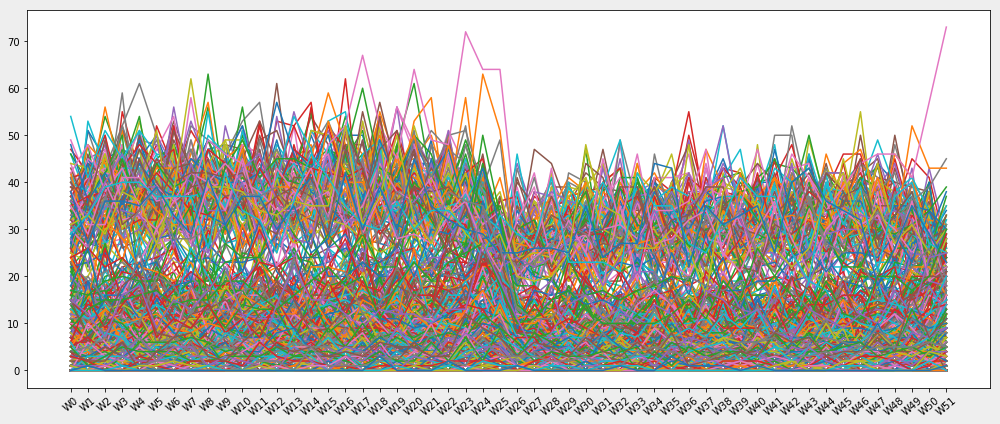

In [8]:
q2_plot(q2_df,1)

In [9]:
q2_df.loc[:,'slope'] = 0
q2_df.loc[:,'growth'] = 0
q2_df.loc[:,'mean_growth'] = 0
q2_df.loc[:,'mean'] = 0
q2_df.loc[:,'bi_w_mean'] = 0
for index,row in q2_df.iterrows():
    y = row.iloc[1:53].values
    x = np.array(range(52))
    coeffs = np.polyfit(x, y, 1)
    q2_df.loc[index,'slope'] = float(coeffs[-2])
    y[y == 0] = 1
    q2_df.loc[index,'growth'] = (y[-1]-y[0])/y[0]
    #sanity check
    #if index == 400:
        #print(row['Product_Code'])
        #print("("+str(row['W51'])+"-"+str(row['W0'])+")/"+str(row['W0']))
    a = np.array(y).astype(float)
    q2_df.loc[index,'mean_growth'] = np.nanmean((a[1:]/a[:-1]))
    q2_df.loc[index,'bi_w_mean'] = np.mean((a[::2] + a[1::2]))
    q2_df.loc[index,'mean'] = np.mean(y)
    #q2_df.loc[index,'mean_growth'] = np.nanmean(np.rate(1,0,-a[:-1],a[1:]))

#### Top 10 products from mean growth

    Product_Code  mean  mean_growth
310         P311  4.40         1.70
668         P673  3.21         1.65
299         P300  4.31         1.65
340         P341  3.29         1.64
398         P401  3.85         1.63
399         P402  3.35         1.62
314         P315  4.00         1.60
368         P370  3.63         1.60
776         P785  2.29         1.59
577         P580  3.38         1.59


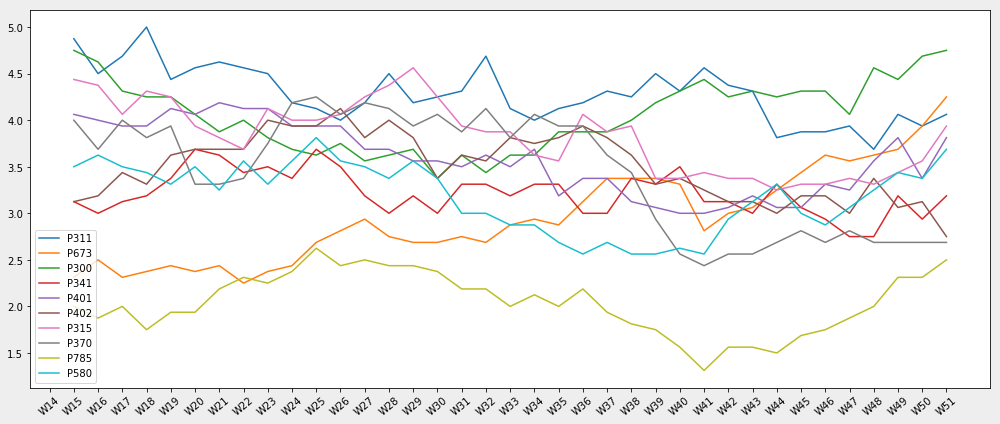

In [10]:
#top 10 products from mean growth
index = q2_df['mean_growth'].sort_values(ascending=False).head(10).index
print(q2_df.loc[index][['Product_Code','mean','mean_growth']])
q2_plot(q2_df.loc[index],16,True)

#### Top 10 highest growth products from week N - week 0 

    Product_Code  mean  growth
799         P808  3.21   13.00
755         P764  3.23   11.00
366         P368  5.40   11.00
759         P768  4.04   10.00
671         P676  3.17    9.00
388         P391  2.73    8.00
606         P609  3.50    8.00
784         P793  3.12    8.00
430         P433  4.08    7.00
254         P255  1.50    7.00


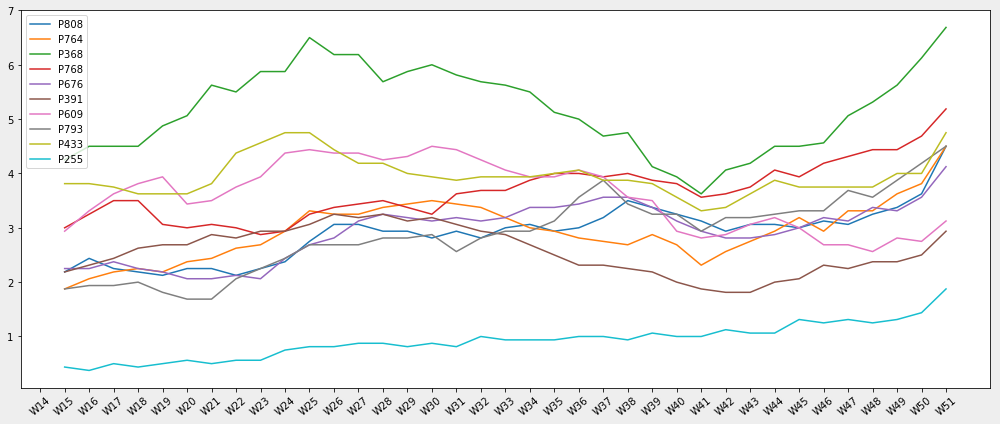

In [11]:
#top 10 product from week N - week 0 growth
index = q2_df['growth'].sort_values(ascending=False).head(10).index
print(q2_df.loc[index][['Product_Code','mean','growth']])
q2_plot(q2_df.loc[index],16,True)

#### Top 10 positive slopes

    Product_Code  mean  slope
669         P674  7.33   0.15
596         P599  3.85   0.12
670         P675  4.44   0.09
201         P202 15.48   0.08
807         P816  2.87   0.08
784         P793  3.12   0.08
698         P703  3.12   0.08
759         P768  4.04   0.07
612         P615 24.33   0.07
597         P600  2.37   0.07


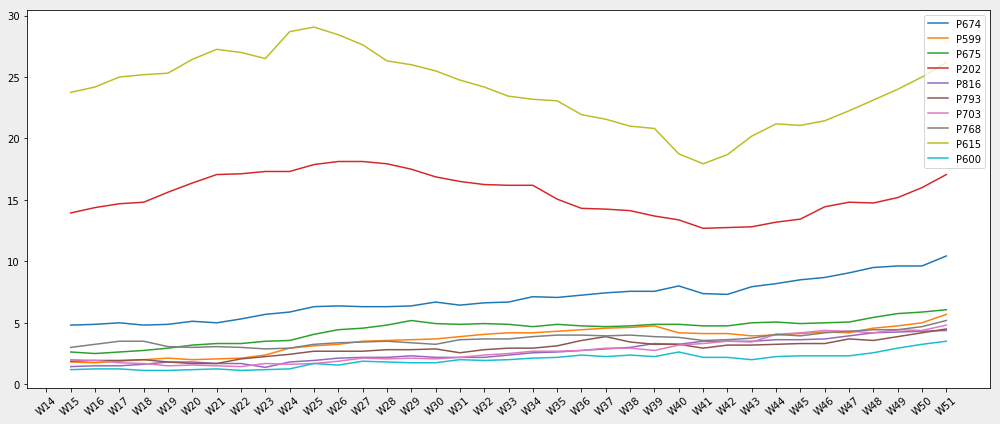

In [12]:
index = q2_df['slope'].sort_values(ascending=False).head(10).index
print(q2_df.loc[index][['Product_Code','mean','slope']])
q2_plot(q2_df.loc[index],16,True)

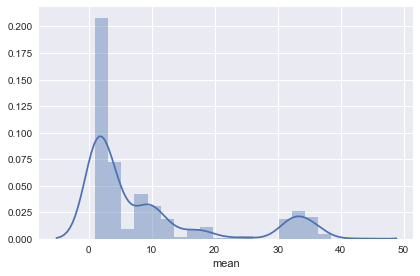

In [13]:
q2_df['mean']
sns.set(color_codes=True)
_ = sns.distplot(q2_df['mean'])
plt.tight_layout()

In [14]:
#print(q2_df[(q2_df['mean'] > 0) & (q2_df['mean'] <= 1) ].count()['Product_Code'])
#for i in range(43):
#    j = q2_df[(q2_df['mean'] > i) & (q2_df['mean'] <= i+1) ].count()['Product_Code']
#    print(str(i)+" "+str(j))

In [15]:
q2_df['mean'].describe()

count   811.00
mean      9.18
std      11.21
min       1.00
25%       1.10
50%       3.85
75%      11.06
max      42.69
Name: mean, dtype: float64

#### Top 10 positive growth and slope  with highest mean

    Product_Code  mean  slope  growth  mean_growth  W0  W51   vol
406         P409 42.69   0.00    0.74         1.05  42   73  2220
612         P615 24.33   0.07    1.29         1.07  17   39  1265
610         P613 22.17   0.04    0.67         1.08  18   30  1153
509         P512 18.52   0.03    1.06         1.07  17   35   963
267         P268 18.46   0.03    0.22         1.07  18   22   960
532         P535 18.25   0.00    1.47         1.12  15   37   949
637         P640 16.67   0.03    0.29         1.08  14   18   867
407         P410 16.54   0.05    4.17         1.11   6   31   860
772         P781 16.44   0.04    2.33         1.07   9   30   855
400         P403 15.83   0.04    1.08         1.08  12   25   823


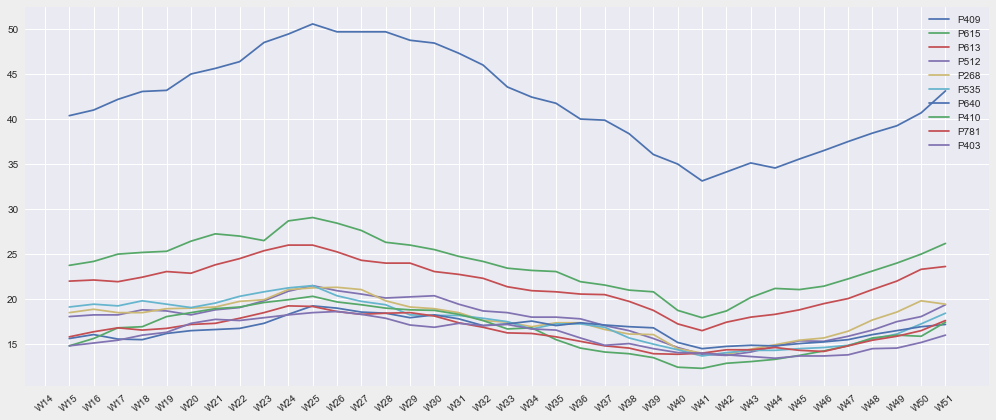

In [16]:
index = q2_df[(q2_df['growth']>0) & (q2_df['slope']>0)].sort_values(by=['mean','growth'],ascending=[False,False]).head(10).index
print(q2_df.loc[index][['Product_Code','mean','slope','growth','mean_growth','W0','W51','vol']])
q2_plot(q2_df.loc[index],16,True)

#### (b) The most promising product (emerging product) is:

From P615 to P403 have potential to be on top in coming year with positive trend and growth.<br>
But if to select one product I believe would be <strong>P410</strong> because of having the highest growth rate of more than 40% and is getting trackion since with only 6 sales by Week 0 and 31 sales at the end of week 51. In comparison with other products at Week 0, P410 is relatively unpopular.

#### TODO
* Use Regression with first semi-annual as train and test then forecast for next year

In [17]:
#just to simulate the mean of bi weekly based on 2 definitions
#https://en.wikipedia.org/wiki/Biweekly
a = np.random.randint(100,300,size=6)
b = a[::2] + a[1::2] #occurring every two weeks
c = a[1:] + a[:-1]
print(np.mean(a))
print(np.mean(b))
print(np.mean(c))

223.5
447.0
438.2


In [18]:
index = q2_df.sort_values(by=['bi_w_mean','slope','mean_growth'],ascending=[True,True,True]).head(10).index
print(q2_df.loc[index][['Product_Code','mean','bi_w_mean','W0','W51','growth','mean_growth','slope']])

    Product_Code  mean  bi_w_mean  W0  W51  growth  mean_growth  slope
259         P260  1.00       2.00   0    0    0.00         1.00  -0.01
709         P716  1.00       2.00   1    0    0.00         1.00  -0.00
708         P715  1.00       2.00   0    0    0.00         1.00  -0.00
662         P667  1.00       2.00   1    0    0.00         1.00  -0.00
707         P714  1.00       2.00   0    0    0.00         1.00  -0.00
379         P381  1.00       2.00   0    0    0.00         1.00  -0.00
470         P473  1.00       2.00   0    0    0.00         1.00  -0.00
754         P763  1.00       2.00   0    0    0.00         1.00  -0.00
656         P661  1.00       2.00   0    0    0.00         1.00  -0.00
703         P708  1.00       2.00   0    0    0.00         1.00  -0.00


##### Identify the worst performing product on a biweekly basis
<strong>P260</strong> should have the worst performing product (I think even on weekly basis)


In [19]:
#plt.figure(figsize=(14,14))
#sns.set(context='notebook', style='whitegrid')
#plt.axlabel(xlabel="Week", ylabel="Vol", fontsize=16)
#sns.boxplot(data=q2_df[weeks_list].values,orient="v",palette="Set3",linewidth=2.5)
#plt.tight_layout()

In [20]:
x = np.array([[0,1,2],[3,4,5]])
print(x)
print(x.shape)
np.swapaxes(x,0,1)

[[0 1 2]
 [3 4 5]]
(2, 3)


array([[0, 3],
       [1, 4],
       [2, 5]])

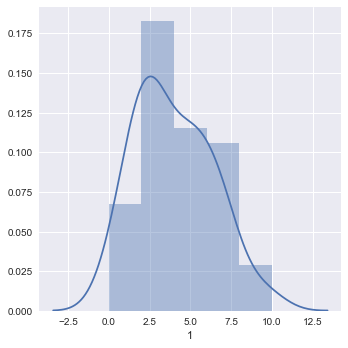

In [21]:
plt.figure(figsize=(5,5))
sns.set(color_codes=True)
#_ = sns.distplot(q2_df.iloc[0,1:53])
_ = sns.distplot(q2_df.iloc[1,1:53])
plt.tight_layout()

#### Outlier checking across columns
Well, looks like all weeks have at least one outliers

In [22]:
#TODO sanity check
iqrx = iqr(q2_df.iloc[:,1:53],axis=0)
print(iqrx.shape)
#use mean instead of median
start = q2_df.iloc[:,1:53].mean()
#print((mean+iqrx*1.5).shape)
outliers = q2_df.iloc[:,1:53][(q2_df.iloc[:,1:53] > (start+iqrx*1.5)) | (q2_df.iloc[:,1:53] < (start-iqrx*1.5))]
print(outliers.dropna(axis=1, how='all', thresh=135).shape)
print(outliers.dropna(axis=0, how='all').shape) #drop nan rows
print(outliers.dropna(axis=0, how='all', thresh=50).shape)
outliers.dropna(axis=0, how='all').head(5)

(52,)
(811, 0)
(161, 52)
(2, 52)


,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
9,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,24.00,nan,nan,nan,nan,nan,nan
14,nan,45.00,47.00,42.00,nan,44.00,43.00,36.00,nan,52.00,...,38.00,35.00,33.00,30.00,37.00,30.00,30.00,34.00,38.00,nan
15,30.00,nan,nan,43.00,nan,32.00,49.00,41.00,49.00,38.00,...,40.00,30.00,33.00,39.00,42.00,45.00,31.00,31.00,nan,nan
16,49.00,40.00,40.00,nan,40.00,47.00,44.00,45.00,39.00,33.00,...,36.00,31.00,36.00,35.00,43.00,28.00,30.00,30.00,nan,nan
17,40.00,38.00,39.00,38.00,39.00,33.00,nan,44.00,36.00,36.00,...,30.00,29.00,29.00,41.00,35.00,nan,28.00,29.00,29.00,nan


#### Outlier checking across Products


In [23]:
outliers_dic = {}
for i,r in q2_df.iterrows():
    iqrx = iqr(q2_df.iloc[i,1:53])
    median = np.ma.median(q2_df.iloc[i,1:53])
    outliers = q2_df.iloc[i,1:53][(q2_df.iloc[i,1:53] > (median+iqrx*1.5)) | (q2_df.iloc[i,1:53] < (median-iqrx*1.5))]
    if not outliers.empty:
        #print(outliers.index)
        outliers_dic[r['Product_Code']] = [i for i in outliers.index ]

In [24]:
print("Total:",len(outliers_dic))
#print first 10
i = 0 ;
for k in outliers_dic:
    print(k,":",outliers_dic[k])
    if i >= 9:
        break
    i = i+1

Total: 743
P167 : ['W27']
P251 : ['W48']
P229 : ['W2', 'W7', 'W10', 'W13', 'W31', 'W38', 'W39', 'W42', 'W48']
P585 : ['W24', 'W25', 'W27', 'W39', 'W41', 'W42', 'W49']
P566 : ['W11', 'W36', 'W46', 'W49']
P659 : ['W3', 'W14', 'W35', 'W38', 'W44', 'W51']
P374 : ['W25', 'W27', 'W28', 'W42', 'W47', 'W49']
P234 : ['W4', 'W21', 'W50']
P8 : ['W12', 'W26', 'W36', 'W40', 'W43', 'W44', 'W49']
P417 : ['W22', 'W24', 'W40', 'W44']


#### (e) Identify outliers from the data and output the corresponding week numbers:

There are about 743 products suspected to have outliers. The 10 out of 743 products with it corresponding week numbers were shown above

#### TODO
* Use the normalization columns to explore the outliers